In [7]:
import geopandas as gpd
import shapely
from shapely.geometry import box, LineString, Point,MultiPoint
from shapely.ops import nearest_points
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import networkx as nx
import re
#from geopy import distance
from math import radians, degrees, sin, cos, asin, acos, sqrt, floor
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from shapely.geometry import shape
import fiona
import itertools
#import osm2gmns as og
import osmnx as ox

In [2]:
# input: filename of shapefile (assuming already in correct directory) 
# output: geopandas dataframe 
def read_file(filename):
    # Set filename
    filename = filename
    # Read file 
    data_out = gpd.read_file(filename)
    return data_out

In [3]:
cwd = os.getcwd() 
cwd

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Code'

## Choose the study area as a subset of PGH neighborhoods

In [13]:
new_dir = cwd.replace('Code', 'Data/PGH_neighborhoods/')
os.chdir(new_dir)
pgh_nhoods = read_file("Neighborhoods_.shp")   # https://data.wprdc.org/dataset/neighborhoods2
# Select a subset of neighborhoods for which the analysis will be conducted
hood_list = pgh_nhoods['hood'].tolist()
hood_keep = [ 'Central Oakland', 'North Oakland', 'Squirrel Hill North', 'Squirrel Hill South', 'Shadyside']  # smaller list for testing
pgh_nhoods_mask = pgh_nhoods[pgh_nhoods['hood'].isin(hood_keep)]  # subset the nhood polygon layer
# dissolve the neighborhoods together
pgh_nhoods_union = pgh_nhoods_mask.dissolve()

In [118]:
pgh_nhoods_union.to_pickle('pgh_study_area.csv')

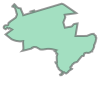

In [14]:
pgh_nhoods_union['geometry'][0]

## Call osmnx package to obtain unimodal networks for driving and biking

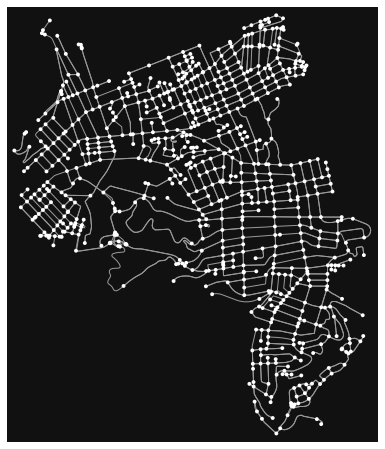

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [19]:
# Drive
G_drive = ox.graph_from_polygon(pgh_nhoods_union['geometry'][0], network_type='drive', retain_all=False)
# retain_all = False argument means that the smaller disconnected network is not retained
ox.plot_graph(G_drive)

In [17]:
len(G_drive.nodes)
len(G_drive.edges)
G_drive.nodes[104198595]
G_drive.edges[(104198595, 104822545, 0)]

757

1983

{'y': 40.4373203, 'x': -79.9541349, 'street_count': 1}

{'osmid': 11945577,
 'name': 'Melba Place',
 'highway': 'residential',
 'oneway': False,
 'length': 78.906,
 'geometry': <shapely.geometry.linestring.LineString at 0x7fb992cb0970>}

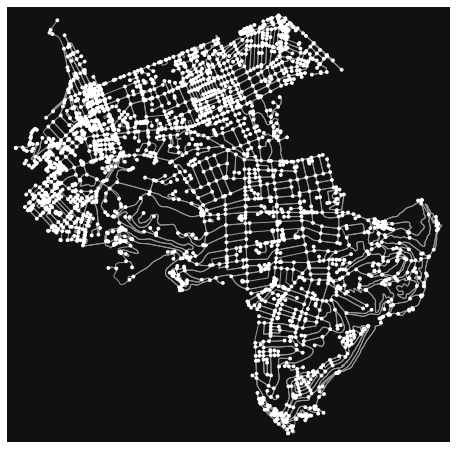

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [20]:
# Bike
G_pb = ox.graph_from_polygon(pgh_nhoods_union['geometry'][0], network_type='bike', retain_all=False)
ox.plot_graph(G_pb)

In [21]:
# Plot the graph using my own plotting function
# node_coords = dict(zip(G.nodes, list(zip(nx.get_node_attributes(G, 'x').values(), nx.get_node_attributes(G, 'y').values()))))
# fig, ax = plt.subplots(figsize=(15,15))
# nx.draw(G, pos=node_coords, with_labels=False, font_color='white',  font_weight = 'bold',
#         node_size=20, node_color='blue', edge_color='grey', width=1, arrowsize=10, ax=ax)

In [22]:
len(G_pb.nodes)
len(G_pb.edges)
G_pb.edges[(104191960, 104191966, 0)]

2574

6299

{'osmid': 11652314, 'highway': 'service', 'oneway': False, 'length': 55.839}

Observe that the biking network is much larger than the driving network. Probably because it includes side streets that are not drivable by cars. Let's investigate the type of roads included in the driving vs. biking networks

In [90]:
df_bike_edges = nx.to_pandas_edgelist(G_pb)
print('Types of roads included in bike networks:')
set(df_bike_edges['highway'].explode().unique())  # this checks out for bike-appropriate roads 

Types of roads included in bike networks:


{'cycleway',
 'path',
 'pedestrian',
 'primary',
 'primary_link',
 'residential',
 'secondary',
 'secondary_link',
 'service',
 'tertiary',
 'tertiary_link',
 'track',
 'trunk',
 'trunk_link',
 'unclassified'}

In [91]:
df_drive_edges = nx.to_pandas_edgelist(G_drive)
print('Types of roads included in bike networks:')
set(df_drive_edges['highway'].explode().unique())  # this checks out for drive-appropriate roads 

Types of roads included in bike networks:


{'busway',
 'motorway_link',
 'primary',
 'primary_link',
 'residential',
 'secondary',
 'secondary_link',
 'tertiary',
 'tertiary_link',
 'trunk',
 'trunk_link',
 'unclassified'}

For a summary of road type descriptions, see: https://wiki.openstreetmap.org/wiki/Highways

In [113]:
def nx_nodes_to_csv(G):
    df = pd.DataFrame.from_dict(dict(G.nodes), orient="index").reset_index()
    df.rename(columns = {'index':'nodeID'}, inplace=True)
    return(df)

In [114]:
# also convert graph nodes to csv files
df_bike_nodes = nx_nodes_to_csv(G_pb)
df_drive_nodes = nx_nodes_to_csv(G_drive)
df_bike_nodes.head()

,nodeID,y,x,street_count,highway
0,104191960,40.452945,-79.944337,3,NaN
1,104191966,40.452475,-79.944105,1,NaN
2,104198588,40.436835,-79.954642,3,NaN
3,104198595,40.437320,-79.954135,3,NaN
4,104206768,40.437742,-79.948474,3,NaN


## Save network nodes and edges as csv files to be used in PGH_network.ipynb

In [115]:
# save the drive and bike networks to csv files
# first change the working directory
new_dir = cwd.replace('Code', 'Data/OSM_data/')
os.chdir(new_dir)

df_drive_edges.to_csv('osm_drive_edges.csv', index=False)
df_drive_nodes.to_csv('osm_drive_nodes.csv', index=False)
df_bike_edges.to_csv('osm_bike_edges.csv', index=False)
df_bike_nodes.to_csv('osm_bike_nodes.csv', index=False)

In [111]:
df = pd.read_csv('osm_drive_nodes.csv', index_col=0)
df.to_dict(orient='index')

{104198595: {'y': 40.4373203,
  'x': -79.9541349,
  'street_count': 1,
  'highway': nan},
 104250917: {'y': 40.4329874,
  'x': -79.930534,
  'street_count': 4,
  'highway': nan},
 104250922: {'y': 40.4327668,
  'x': -79.9305501,
  'street_count': 1,
  'highway': nan},
 104250998: {'y': 40.4322702,
  'x': -79.9305024,
  'street_count': 4,
  'highway': nan},
 104361652: {'y': 40.4468267,
  'x': -79.9400875,
  'street_count': 3,
  'highway': nan},
 104361659: {'y': 40.4467875,
  'x': -79.9406626,
  'street_count': 1,
  'highway': nan},
 104363212: {'y': 40.4550351,
  'x': -79.9414632,
  'street_count': 3,
  'highway': 'traffic_signals'},
 104371210: {'y': 40.4399943,
  'x': -79.9576053,
  'street_count': 2,
  'highway': nan},
 104383297: {'y': 40.4536225,
  'x': -79.9412451,
  'street_count': 1,
  'highway': nan},
 104383352: {'y': 40.4444714,
  'x': -79.9419585,
  'street_count': 3,
  'highway': nan},
 104439711: {'y': 40.4458875,
  'x': -79.9362049,
  'street_count': 1,
  'highway': nan

In [85]:
# This is the code that will be used to read in the data and prepare for conversion to nx graph
df_drive.head()
cols_keep = ['length', 'ref', 'oneway', 'lanes', 'osmid', 'maxspeed', 'tunnel', 'geometry', 'name', 'highway', 'bridge','junction', 'access']
attr_dict = df_drive[cols_keep].to_dict('index').values()

a = pd.MultiIndex.from_frame(df_drive[['source', 'target']])
wtd_edges = dict(zip(a, attr_dict))
wtd_edges
#wtd_edges = dict(zip(df_drive['edge_key'], attr_dict))

,source,target,length,ref,oneway,lanes,osmid,maxspeed,tunnel,geometry,name,highway,bridge,junction,access,edge_key
0,104198595,104822545,78.906,NaN,False,NaN,11945577,NaN,NaN,"LINESTRING (-79.9541349 40.4373203, -79.953845...",Melba Place,residential,NaN,NaN,NaN,"(104198595, 104822545)"
1,104250917,105083495,125.628,NaN,False,NaN,11736608,NaN,NaN,NaN,Kamin Street,residential,NaN,NaN,NaN,"(104250917, 105083495)"
2,104250917,104250922,25.163,NaN,False,NaN,264432816,NaN,NaN,"LINESTRING (-79.93053399999999 40.4329874, -79...",Murdoch Street,residential,NaN,NaN,NaN,"(104250917, 104250922)"
3,104250917,104687047,84.054,NaN,False,NaN,264433650,NaN,NaN,"LINESTRING (-79.93053399999999 40.4329874, -79...",Murdoch Street,residential,NaN,NaN,NaN,"(104250917, 104687047)"
4,104250922,104250917,25.163,NaN,False,NaN,264432816,NaN,NaN,"LINESTRING (-79.9305501 40.4327668, -79.930564...",Murdoch Street,residential,NaN,NaN,NaN,"(104250922, 104250917)"


{(104198595, 104822545): {'length': 78.906,
  'ref': nan,
  'oneway': False,
  'lanes': nan,
  'osmid': 11945577,
  'maxspeed': nan,
  'tunnel': nan,
  'geometry': <shapely.geometry.linestring.LineString at 0x7fb9765ff160>,
  'name': 'Melba Place',
  'highway': 'residential',
  'bridge': nan,
  'junction': nan,
  'access': nan},
 (104250917, 105083495): {'length': 125.628,
  'ref': nan,
  'oneway': False,
  'lanes': nan,
  'osmid': 11736608,
  'maxspeed': nan,
  'tunnel': nan,
  'geometry': nan,
  'name': 'Kamin Street',
  'highway': 'residential',
  'bridge': nan,
  'junction': nan,
  'access': nan},
 (104250917, 104250922): {'length': 25.163,
  'ref': nan,
  'oneway': False,
  'lanes': nan,
  'osmid': 264432816,
  'maxspeed': nan,
  'tunnel': nan,
  'geometry': <shapely.geometry.linestring.LineString at 0x7fb97689bc10>,
  'name': 'Murdoch Street',
  'highway': 'residential',
  'bridge': nan,
  'junction': nan,
  'access': nan},
 (104250917, 104687047): {'length': 84.054,
  'ref': nan

## Next steps
1. Clean up this code. This file will read in the Pittsburgh Neighborhood shapefile and deterine an appropriate study area. The study area will be aggregated to a single polygon.
1. Using this "neighborhood mask", the OSM network will be downloaded using the osmnx python package. This package allows for one to specify the network of interest (options include: ). We will just download the auto and bike networks. 
1. The osmnx package returns a bidirectional nx graph. We will save this graph as a df using nx.to_pandas_edgelist. This will be done for both the auto graph and the bike graph
1. Then we will return to the PGH_network.ipynb file. In that file, we will read in the graphs using nx.from_pandas_edgelist. Then we can proceed with that file as before. Ensure that these new graphs are compatible with previous processes.
1. Use zipcar data and import into PGH_newtwork.ipynb. I think the way to handle zipcar is trip chaining: start from origin and route TO depot. to ensure that you only use zipcar rest of the way, only one "shortcut" edge will emerge from the depot. How to calculate cost of shortcut edge? Say there are 5 destinations. Build edge from depot to nearest neighbor on zipcar network (a copy of the auto network without driving). Find shortest path from nn point to destination.

## Zipcar data

In [54]:
new_dir = cwd.replace('Code','Data/')
os.chdir(new_dir)
df_zip = pd.read_csv('Zipcar_Depot.csv')
df_zip.head()

,WKT,name,description
0,POINT (-79.99926719999999 40.43868959999999),Zipcar,NaN
1,POINT (-79.9524014 40.4640436),Zipcar,NaN
2,POINT (-79.9165142 40.4576502),Zipcar,NaN
3,POINT (-79.9224177 40.4325169),Zipcar,NaN
4,POINT (-79.9322761 40.4604655),Zipcar,NaN


In [82]:
zip_gdf = gpd.GeoDataFrame(data=df_zip, geometry=df_zip['WKT'].apply(wkt.loads), crs='EPSG:4326').reset_index()[['index','geometry']]
zip_gdf.head()

,index,geometry
0,0,POINT (-79.99927 40.43869)
1,1,POINT (-79.95240 40.46404)
2,2,POINT (-79.91651 40.45765)
3,3,POINT (-79.92242 40.43252)
4,4,POINT (-79.93228 40.46047)
